In [1]:
import sys
sys.path.insert(0,'../code')

In [2]:
import pytorch_lightning as pl
seed = pl.seed_everything(25)

Global seed set to 25


In [3]:
from argparse import Namespace
args = Namespace(
    base_model="ViT",
    checkpoint="../checkpoints/ViT_toy 3x3/epoch=99-step=15000.ckpt",
    from_pretrained="../checkpoints/ViT_toy 3x3",
    weighted_layer_distribution=True,
    dataset="toy",
    class_idx=3,
    grid_size=3,
    batch_size=5,
    add_noise=False,
    add_rotation=False,
    add_blur=False,
    num_workers=4,
)

### Load model from checkpoint

In [4]:
from models.interpretation import ImageInterpretationNet
from transformers import ViTForImageClassification

In [5]:
# Initialize the ViT and DiffMask models from the checkpoint
vit_model = ViTForImageClassification.from_pretrained(args.from_pretrained)
diffmask_model = ImageInterpretationNet.load_from_checkpoint(
    args.checkpoint,
    model_cfg=vit_model.config,
)
diffmask_model.set_vision_transformer(vit_model)
diffmask_model.eval();

### Generate sample images

In [6]:
from datamodules.utils import datamodule_factory

In [7]:
dm = datamodule_factory(args)
dm.prepare_data()
dm.setup("test")
X, Y = next(iter(dm.test_dataloader()))

### Compute DiffMask masks

In [8]:
out = diffmask_model.get_mask(X)
masks = out["mask"].detach()

### Visualize results

In [9]:
from utils.plot import draw_mask_on_image, unnormalize
import matplotlib.pyplot as plt
import torch

In [10]:
def add_transparency(image):
    t_zero = torch.tensor(0.)

    C, H, W = image.shape
    image = image.reshape(C, -1)
    for i, patch in enumerate(image.sum(dim=0)):
        if patch.sum().allclose(t_zero):
            image[:, i] = 1

    return image.reshape(C, H, W)

def get_classname(idx):
    if hasattr(dm.feature_extractor, "id2label"):
        return dm.feature_extractor.id2label[idx]
    elif idx == 1:
        return "1 instance"
    else:
        return f"{idx} instances"

def plot(ax, image):
    ax.imshow(image.permute(1,2,0))
    ax.axis("off")

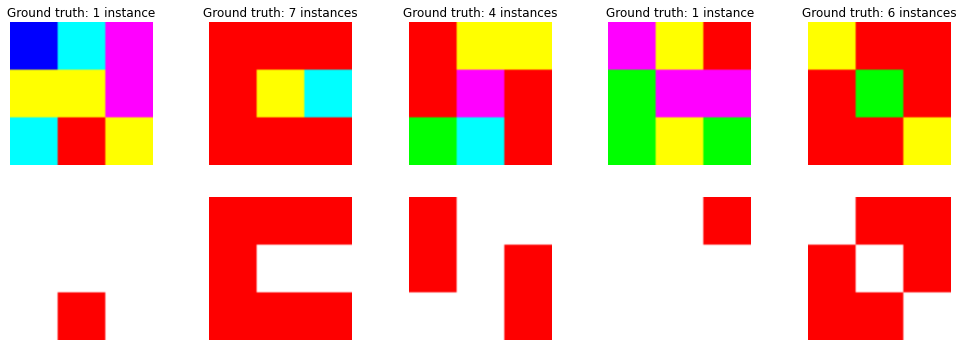

In [11]:
_, axs = plt.subplots(2, len(X), figsize=(14, 5))
plt.tight_layout()

for i, (img, mask, y) in enumerate(zip(unnormalize(X), masks, Y)):
    masked_img = draw_mask_on_image(img, mask)
    masked_img = add_transparency(masked_img)

    plot(axs[0][i], img)
    plot(axs[1][i], masked_img)
    axs[0][i].set_title(f"Ground truth: {get_classname(y.item())}")

plt.savefig("toy.jpg", dpi=300)